In [1]:
import numpy as np
import pandas as pd
import cv2
import glob
import time
from random import randint
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from skimage.feature import hog
from skimage.measure import label
from skimage.measure import regionprops
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# some commonly used functions
def read_image(image_path):
    """
        read the image in the given path
        as cv2.imread returns BGR images, apply transformation to expected RGB
    """
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
# create separate images from the annotated udacity data
base_path_read = './training/object-dataset/'
base_path_save = './training/generated/'
labels_file = base_path_read + 'labels.csv'
counter = 0

def extract_single_image(image, row):
    global counter
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    # crop_img = img[200:400, 100:300] # Crop from x, y, w, h -> 100, 200, 300, 400
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    cropped = image[ymin:ymax, xmin:xmax]
    file_name = 'image_' + str(counter) + '.jpg'
    counter += 1
    sub_dir = 'car/' if ((row['label'] == 'car') | (row['label'] == 'truck')) else 'notcar/'
    cv2.imwrite(base_path_save + sub_dir + file_name, cropped)

def extract_images():
    data = pd.read_csv(labels_file, 
                   names = ['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'occluded', 'label'],
                   delimiter = ' ')

    image_names = data.image_name.unique()
    for image_name in image_names:
        current = data[data.image_name == image_name]
        current.apply(
            lambda x: extract_single_image(read_image(base_path_read + image_name), x), 
            axis=1
        )

#extract_images()

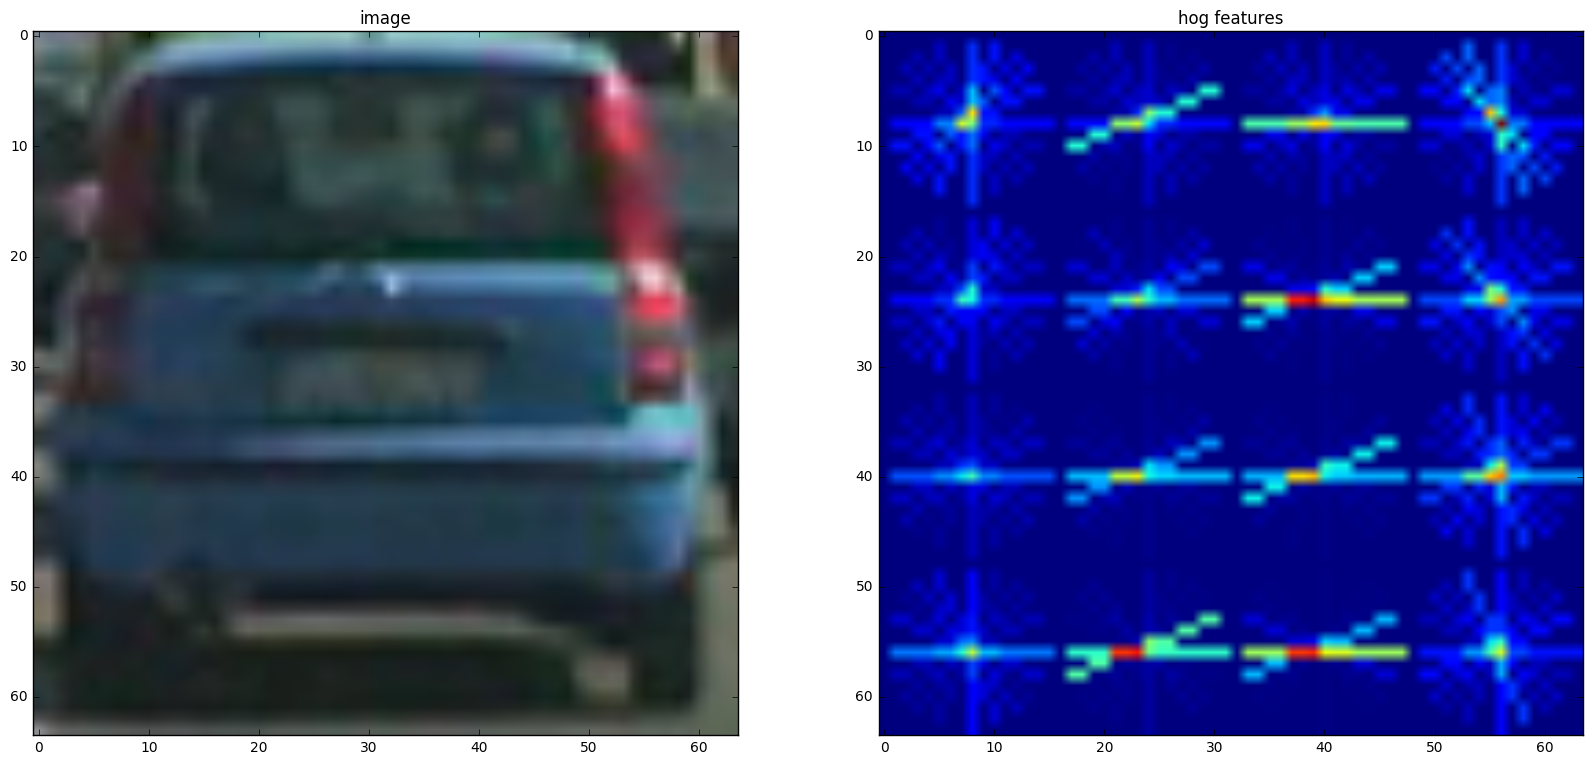

In [4]:
# define methods for feature extraction

# create features based on the histograms of the individual color channels.
def color_histogram_features(image, nbins=32, bins_range=(0, 256), color_space='RGB'):
    if color_space != 'RGB':
        image = cv2.cvtColor(image, cv2.RGB2HLS)
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(image[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(image[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# spatial binning as discussed in the lectures.
def spatial_binning_features(image, size=(32, 32)):
    features = cv2.resize(image, size).ravel()
    return features

# create HOG features of an image as discussd in class
def hog_features(image, orient=10, pix_per_cell=16, cell_per_block=2, visualize=False):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # hog features on l channel proved to be most effective
    features = hog(image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                   visualise=visualize, feature_vector=True)
    return features

image = read_image('./training/vehicles/GTI_MiddleClose/image0240.png')
_, feature_image = hog_features(image, visualize=True)
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,10))
ax0.set_title('image')
ax0.imshow(image)
ax1.set_title('hog features')
ax1.imshow(feature_image)


In [5]:
# Read in car and non-car images
car_images_path = './training/vehicles/GTI*/*'
not_car_images_path = './training/non-vehicles/GTI*/*'
cars = [read_image(x) for x in glob.glob(car_images_path)]
not_cars = [read_image(x) for x in glob.glob(not_car_images_path)]
print('read: ', 'car ', len(cars), ' images and ', len(not_cars), ' non car images')

read:  car  8792  images and  9666  non car images


In [6]:
# compute features and scale them.

# Define a function to extract features from a list of images
def extract_features(images, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    
    features = []
    for image in images:
        # resize for conformity across input
        if (image.shape != (64, 64, 3)):
            image = cv2.resize(image, (64, 64))
        # Apply spatial_binning_features() to get spatial color features
        spatial_features = spatial_binning_features(image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_histogram_features(image, nbins=hist_bins, bins_range=hist_range)
        # hog features
        hog = hog_features(image)

        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog)))
        
    # Return list of feature vectors
    return features

spatial = 32
histbin = 32

car_features = extract_features(cars, spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(not_cars, spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


In [7]:
# define a rudimentary pipeline


# try linear SVC 
lsvc = LinearSVC(class_weight='balanced')

# try sgd
sgd = SGDClassifier(class_weight='balanced')

# try gradient boosting
#gbc = GradientBoostingClassifier()


def train(cls, name):
    # Check the training time for the classifier
    t=time.time()
    cls.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'seconds to train ', name)

    # Check the score of the classifier
    print('Test Accuracy of ', name, ' = ', round(cls.score(X_test, y_test), 4))

    # Check the prediction time for some samples
    t=time.time()
    n_predict = 10
    print(name, ' predicts: ', cls.predict(X_test[0:n_predict]))
    print('For these', n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with ', name)

train(lsvc, 'linearSVC')
train(sgd, 'sgdClassifier')
#train(gbc, 'gradientBoostingClassifier')


10.87 seconds to train  linearSVC
Test Accuracy of  linearSVC  =  0.9848
linearSVC  predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
0.00178 Seconds to predict 10 labels with  linearSVC
0.4 seconds to train  sgdClassifier
Test Accuracy of  sgdClassifier  =  0.9764
sgdClassifier  predicts:  [ 1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  1.  0.  1.  0.  0.]
0.00288 Seconds to predict 10 labels with  sgdClassifier


In [8]:
from sklearn.externals import joblib
joblib.dump(lsvc, 'lsvc.pkl')
joblib.dump(sgd, 'sgd.pkl')
#joblib.dump(gbc, 'gbc.pkl')

['sgd.pkl']

In [24]:
# sliding window implementation
def get_sliding_windows(image, cls, roi=[(0, 0), (1280, 720)], 
                        xy_windows=[(64, 64), (96, 96), (128, 128)], 
                        xy_overlap=(0.5, 0.5)):

    # Initialize a list to append window positions to
    window_list = []
    
    for xy_window in xy_windows:
        # Compute the span of the region to be searched    
        xspan = roi[1][0] - roi[0][0]
        yspan = roi[1][1] - roi[0][1]

        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1



        # Loop through finding x and y window positions
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + roi[0][0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + roi[0][1]
                endy = starty + xy_window[1]
                # Append window position to list
                area = image[starty:endy, startx:endx]
                features = extract_features([area])
                features = X_scaler.transform(features)
                match = cls.predict(features)
                if match == 1.9:
                    window_list.append(((startx, starty), (endx, endy)))

    return window_list

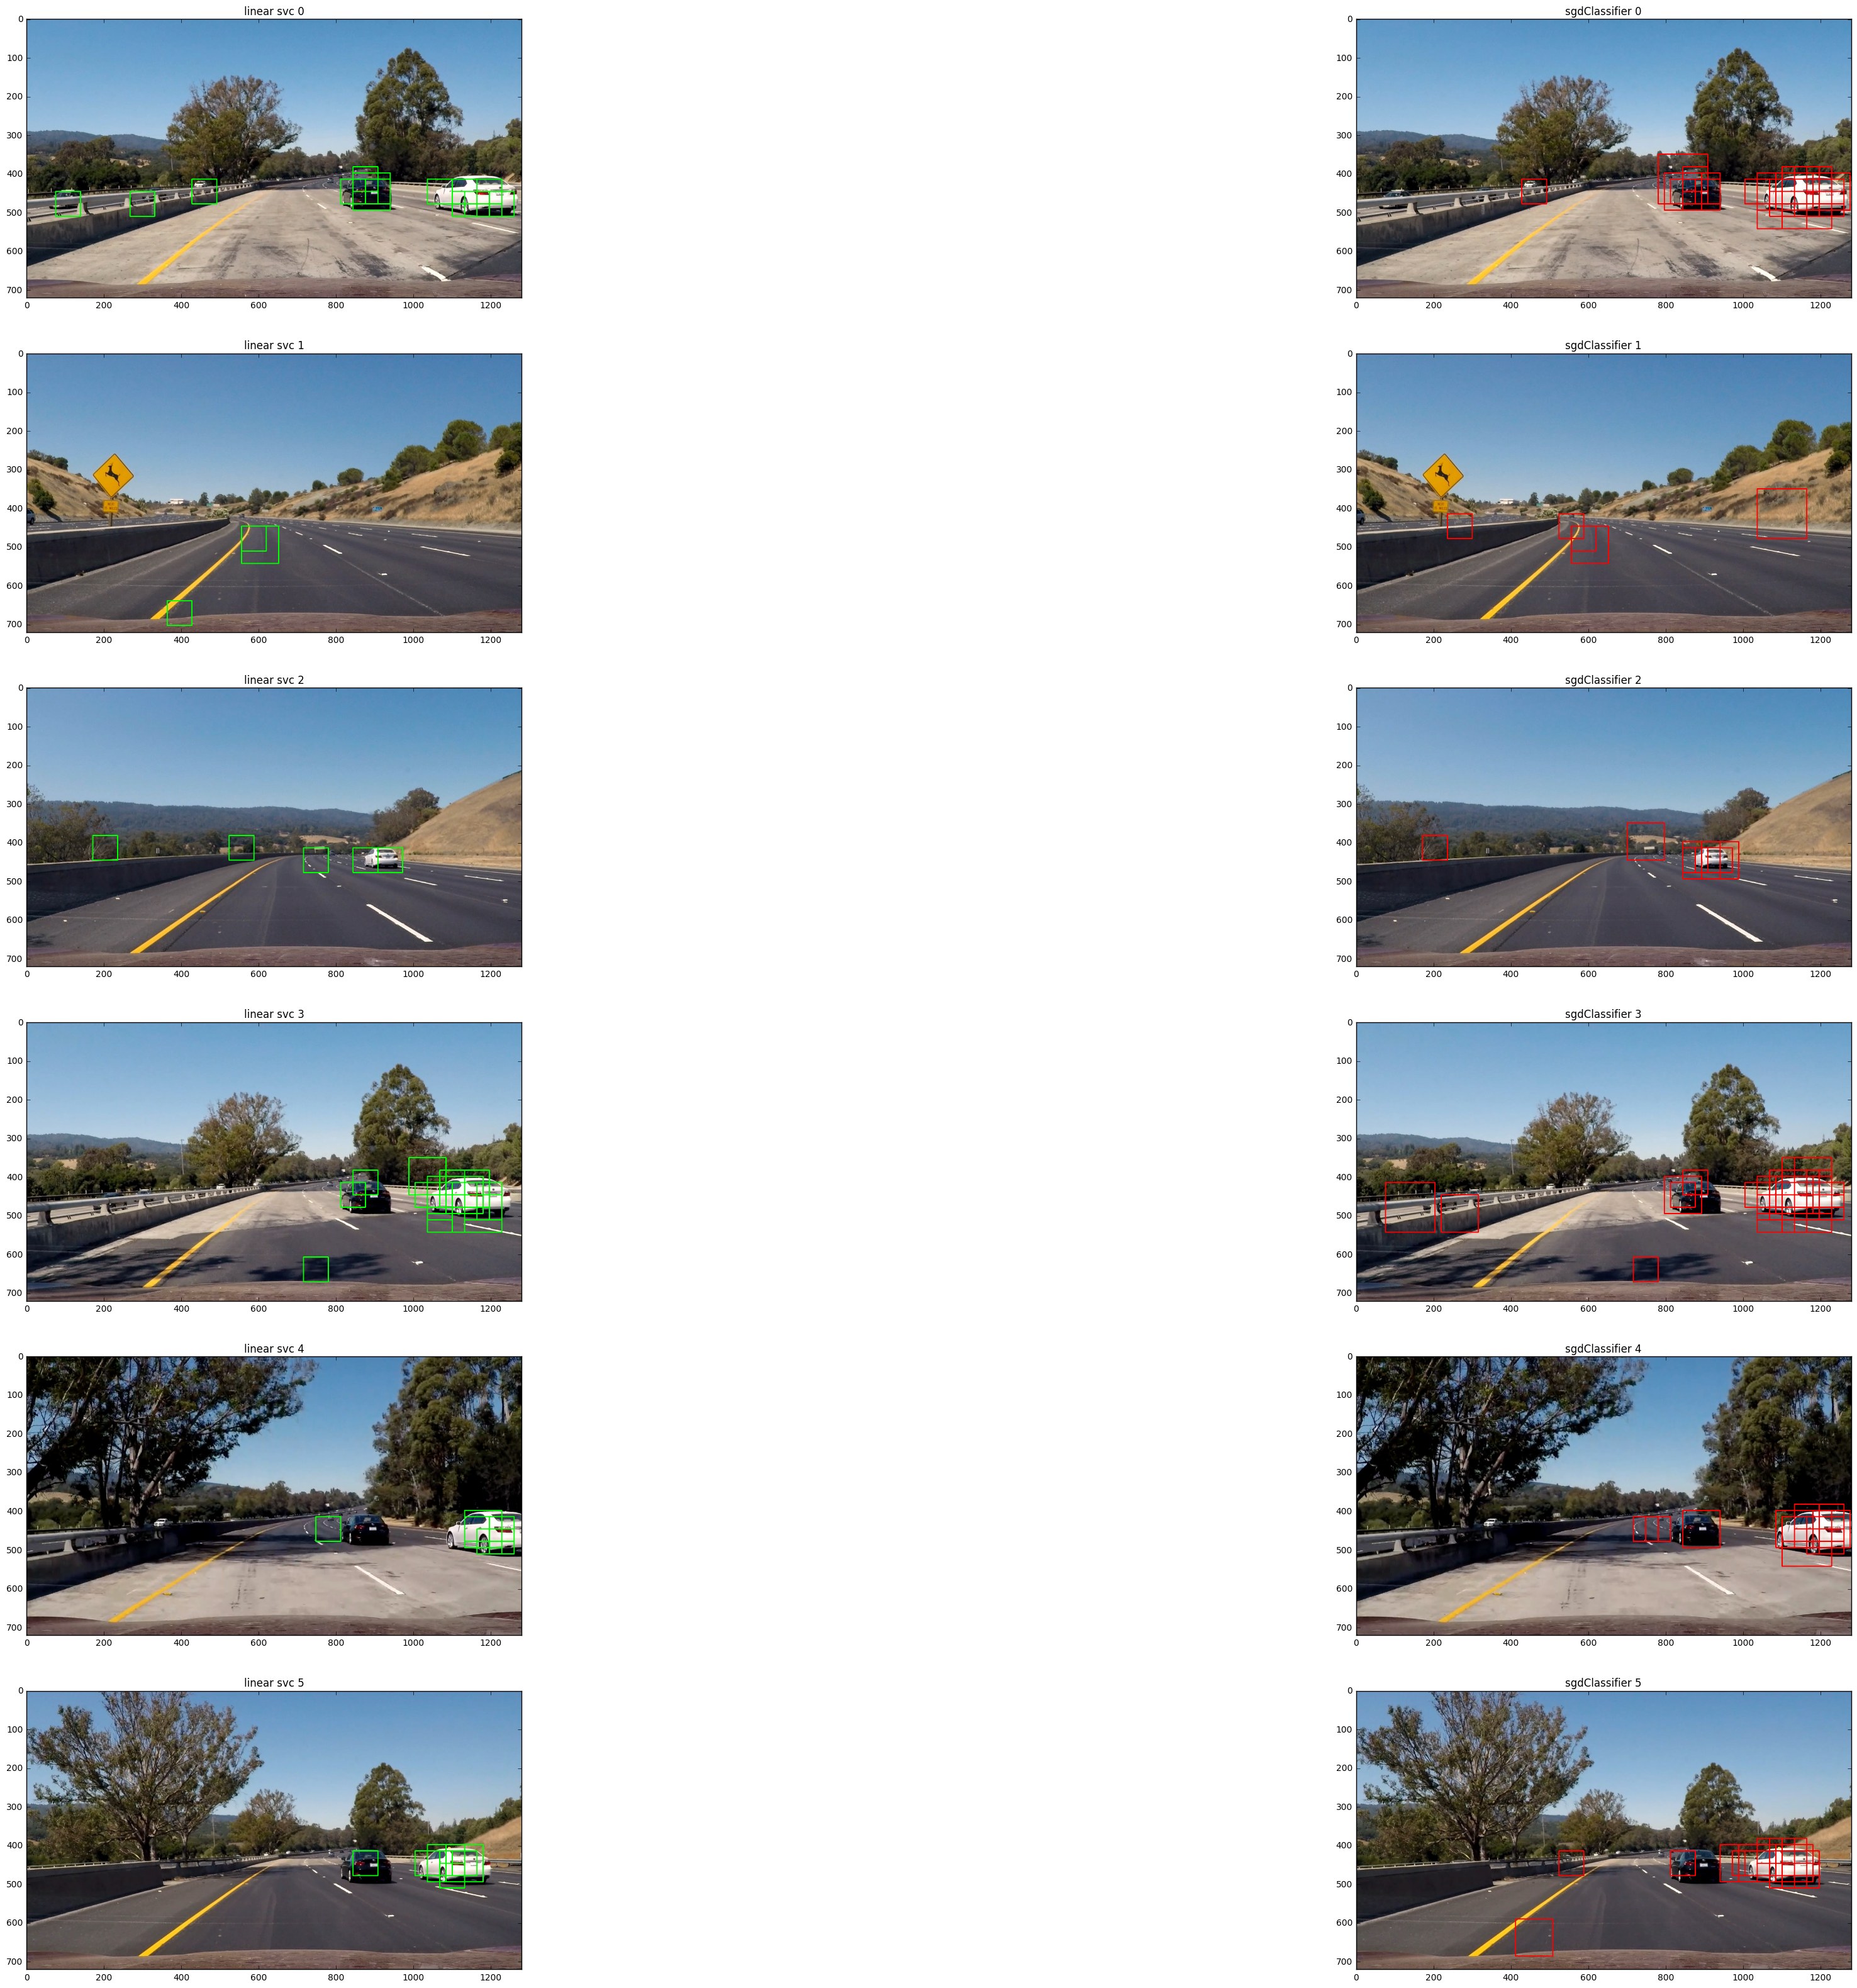

In [25]:
# Just visualize how sliding window look like
test_images = glob.glob('./training/*.jpg')
f, ax = plt.subplots(6, 2, figsize=(50,40))

for idx, image_path in enumerate(test_images):
    test_img = read_image(image_path)
    copy = np.copy(test_img)

    windows_lsvc = get_sliding_windows(test_img, lsvc, roi=[(75,350), (1280,720)])
    windows_sgd = get_sliding_windows(test_img, sgd, roi=[(75,350), (1280,720)])

    for p1, p2 in windows_lsvc:
        cv2.rectangle(test_img, p1, p2, (0,255,0), 2)

    for p1, p2 in windows_sgd:
        cv2.rectangle(copy, p1, p2, (255,0,0), 2)

    ax[idx][0].set_title('linear svc ' + str(idx))
    ax[idx][0].imshow(test_img)
    ax[idx][1].set_title('sgdClassifier ' + str(idx))
    ax[idx][1].imshow(copy)
    


In [26]:
# use heatmap to cluster detections
def get_heatmap_from_image(image, cls):
    # Get all sliding windows and image patches
    windows = get_sliding_windows(image, cls)
    
    # Define heatmap as zeros image
    heatmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    for window in windows:
        xleft, yleft = window[0]
        xright, yright = window[1]
        heatmap[yleft:yright, xleft:xright] += 1

    return heatmap

In [27]:
# extract regions from heatmap
def get_windows_from_heatmap(heatmap, threshold=1):
    # If heatmap is empty, no boundaries
    if(heatmap.max() == 0):
        return []
    
    # filter
    mask = np.zeros_like(heatmap)
    mask[heatmap > threshold] = 1
    
    # Use skimage.measure.label to label regions on the mask
    labeled = label(mask)
    
    result = []
    # Use skimage.measure.regionprops to get continuous regions in the image
    for region in regionprops(labeled):        
        minr, minc, maxr, maxc = region.bbox
        result.append(((minc, minr), (maxc, maxr)))

    return result

In [28]:
# convenience function to combine sliding windows and heatmap generation
def get_trackable_windows(image, cls):
    heatmap = get_heatmap_from_image(image, cls)
    return get_windows_from_heatmap(heatmap)

In [29]:

class Window():
    """
        representation of windows believed to contain a vehicle
        used for tracking vehicles across frames
    """
    def __init__(self, window, distance_threshold=200):
        self.window = window
        self.center = self._get_center()
        self.distance_threshold = distance_threshold
    
    def distance_to(self, other_window):
        x1, y1 = self.center
        x2, y2 = other_window._get_center()
        return np.sqrt((x1-x2)**2 + (y1-y2)**2)
    
    def is_within_threshold(self, other_window):
        return self.distance_to(other_window) < self.distance_threshold
    
    def _get_center(self):
        p1, p2 = self.window
        x = int((p1[0] + p2[0]) / 2)
        y = int((p1[1] + p2[1]) / 2)
        return (x, y)

In [30]:
from collections import deque

class Tracker():
    
    def __init__(self, window, drawing_frames=5, death_tolerance=10, max_len=15):
        # keeping track of the last max_len windows and detections
        self.windows = deque([window], max_len)
        self.detections = deque([], death_tolerance)
        
        # some thresholds for deciding to draw or drop a tracker
        self.min_frames_drawing = drawing_frames
        
        # current window matches
        self.matches = False
        
        # last window
        self.last = None
        
    def setup_frame_processing(self):
        self.matches = False
    
    def can_add_window(self, window):
        return window.is_within_threshold(self.windows[-1])
    
    def add_window(self, window):
        """
            add new window to the tracker
            windows should only be added if within the tolerance
        """
        self.windows.append(window)
        self.last = window
        self.detections.append(True)
        self.matches = True

    def is_drawable(self):
        return sum(self.detections) > self.min_frames_drawing
    
    def is_dead(self):
        """
            if there have been no detections in the last frames, the tracker is useless
        """
        for val in self.detections:
            if val == True:
                return False
            
        return True

In [31]:
class VideoProcessor():
    
    def __init__(self, classifier_name='lsvc.pkl'):
        self.classifier = joblib.load(classifier_name)
        self.trackers = []
        
    def prepare_trackers(self):
        for tracker in self.trackers:
            tracker.setup_frame_processing()
            
    def combine_windows(self, window1, window2):
        a1, a2 = window1
        b1, b2 = window2
        a1, a2, b1, b2 = np.array(a1), np.array(a2), np.array(b1), np.array(b2)
        
        avg1 = 0.9 * a1 + 0.1 * b1
        avg2 = 0.9 * a2 + 0.1 * b2
        
        result = ((int(avg1[0]), int(avg1[1])), (int(avg2[0]), int(avg2[1])))
        return result
    
    def draw_window_on_frame(self, frame, window):
        p1, p2 = window
        cv2.rectangle(frame, p1, p2, (0,255,0), 3)
        
    def clear_dead_trackers(self):
        self.trackers = [x for x in self.trackers if not x.is_dead()]
        
    def process_frame(self, frame):
        windows = get_trackable_windows(frame, self.classifier)
        
        self.prepare_trackers()
        
        for window in windows:
            current = Window(window)
            
            is_assigned = False
            is_drawable = False
                        
            # try current window for every tracker to see if there's a match
            for tracker in self.trackers:
                # if matches, append to that tracker and check if it is drawable
                if tracker.can_add_window(current):
                    tracker.add_window(current)
                    
                    if (tracker.last):
                        current = self.combine_windows(tracker.last.window, current.window)
                    tracker.last = current
                    
                    is_assigned = True
                    is_drawable = tracker.is_drawable()
                    
                    # found suitable tracker, abort loop
                    break
                    
            # no match, start tracking the object
            if not is_assigned:
                self.trackers.append(Tracker(current))
                
            if is_drawable:
                self.draw_window_on_frame(frame, current)
        
        self.clear_dead_trackers()
        return frame
    

In [33]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

videoProcessor = VideoProcessor()
def process_video_image(image):
    new_frame = videoProcessor.process_frame(image)
    return new_frame

def process_video(output_path, input_path):
    input_file = VideoFileClip(input_path)
    standard_clip = input_file.fl_image(process_video_image) #NOTE: this function expects color images!!
    %time standard_clip.write_videofile(output_path, audio=False, threads=4)
    return output_path

output = process_video('./training/project_video_out_.mp4', './training/project_video.mp4')

[MoviePy] >>>> Building video ./training/project_video_out_.mp4
[MoviePy] Writing video ./training/project_video_out_.mp4



100%|█████████▉| 1260/1261 [10:34<00:00,  2.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./training/project_video_out_.mp4 

CPU times: user 10min 7s, sys: 8.16 s, total: 10min 15s
Wall time: 10min 36s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))